In [1]:
# Cell 1: Install spaCy and dependencies (run once)
%pip install spacy --quiet

# Download model bahasa Inggris kecil (cukup untuk proyek ini)
!python -m spacy download en_core_web_sm

import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json, os
sns.set_style("whitegrid")

os.makedirs("/content/data", exist_ok=True)
os.makedirs("/content/figures", exist_ok=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 150.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Cell 2: Load cleaned dataset and choose text column
csv_path = "/content/clean_link_emirates.csv"

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"File not found: {csv_path}. Upload clean_link_emirates.csv to /content or change path.")

df = pd.read_csv(csv_path, parse_dates=['date'], low_memory=False)
print("Loaded dataset:", df.shape)
display(df.head(2))

# Choose best text column (prefer lemmatized)
text_col = None
for cand in ["text_lemmatized", "text_after_stop", "content_nopunct", "content_lower", "content_raw"]:
    if cand in df.columns and df[cand].notna().sum() > 0:
        text_col = cand
        break

if text_col is None:
    raise ValueError("No suitable text column found. Columns: " + ", ".join(df.columns.tolist()))

print("Using text column for NLP:", text_col)

Loaded dataset: (150, 13)


,url,title,date,content_raw,content_lower,content_nopunct,text_before_stop,text_after_stop,text_lemmatized,wc_raw,wc_nopunct,wc_before,wc_after
0,https://www.emirates.com/media-centre/the-emir...,"‘The Emirates App’ now launches on iPhone, ope...",2014-11-16,"Dubai, UAE, 16 November 2014 – Building on the...",dubai uae 16 november 2014 – building on the s...,dubai uae november building on the s...,dubai uae 16 november 2014 – building on the s...,dubai uae november building successful launch ...,dubai uae november building successful launch ...,432,432,444,265
1,https://www.emirates.com/media-centre/emirates...,"Emirates expands its mobile footprint, launche...",2015-05-18,The Emirates App now available on the world’s ...,the emirates app now available on the world’s ...,the emirates app now available on the world s ...,the emirates app now available on the world ’ ...,emirates app available world largest mobile pl...,emirate app available world large mobile platf...,451,456,466,265


Using text column for NLP: text_lemmatized


In [3]:
# Cell 3: Load spaCy model (and do a quick warm-up)
nlp = spacy.load("en_core_web_sm", disable=["lemmatizer"])  # keep POS, NER enabled
# warm-up on a short text to initialize model
_ = nlp("This is a quick spaCy warm-up.")
print("spaCy model loaded:", nlp.meta.get("name"))

spaCy model loaded: core_web_sm


Saved POS counts -> /content/data/pos_distribution.csv


/tmp/ipython-input-4213798685.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="POS", data=pos_df, palette="crest")


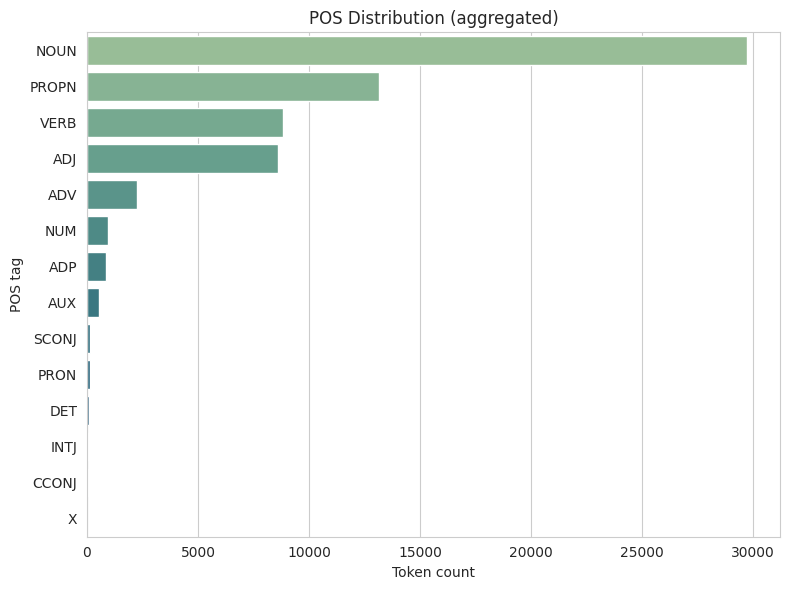

Saved POS plot -> /content/figures/pos_distribution.png


,POS,count
3,NOUN,29722
0,PROPN,13147
1,VERB,8821
2,ADJ,8622
4,ADV,2246
9,NUM,952
7,ADP,856
8,AUX,554
6,SCONJ,149
12,PRON,144


In [4]:
# Cell 4: POS tagging distribution (aggregated)
from collections import Counter
pos_counts = Counter()

# Process in batches for speed
texts = df[text_col].fillna("").astype(str).tolist()
for doc in nlp.pipe(texts, batch_size=64):
    pos_counts.update([token.pos_ for token in doc])

pos_df = pd.DataFrame(pos_counts.items(), columns=["POS", "count"]).sort_values("count", ascending=False)
pos_df.to_csv("/content/data/pos_distribution.csv", index=False)
print("Saved POS counts -> /content/data/pos_distribution.csv")

# Plot (horizontal)
plt.figure(figsize=(8,6))
sns.barplot(x="count", y="POS", data=pos_df, palette="crest")
plt.title("POS Distribution (aggregated)")
plt.xlabel("Token count")
plt.ylabel("POS tag")
plt.tight_layout()
plt.savefig("/content/figures/pos_distribution.png", dpi=300)
plt.show()
print("Saved POS plot -> /content/figures/pos_distribution.png")

display(pos_df.head(12))

Saved NER label counts -> /content/data/ner_label_counts.csv
Saved top entities per label -> /content/data/ner_top_entities.json


/tmp/ipython-input-49815641.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="label", data=ent_df, palette="flare")


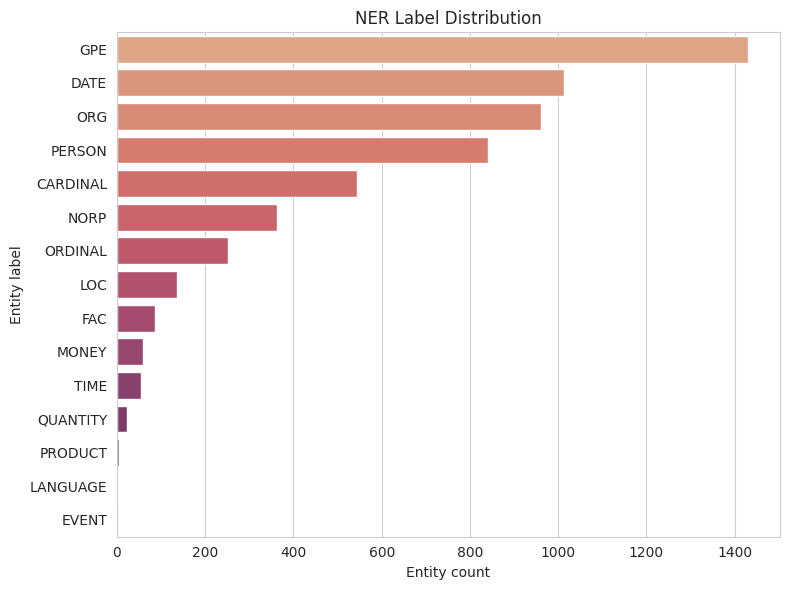

Saved NER plot -> /content/figures/ner_label_distribution.png


,label,count
0,GPE,1431
1,DATE,1013
2,ORG,960
5,PERSON,841
4,CARDINAL,544
6,NORP,362
3,ORDINAL,252
7,LOC,137
11,FAC,87
10,MONEY,59


In [5]:
# Cell 5: NER aggregation (labels + top entities per label)
ent_counter = Counter()
per_label = {}

for doc in nlp.pipe(texts, batch_size=64):
    for ent in doc.ents:
        ent_counter[ent.label_] += 1
        per_label.setdefault(ent.label_, Counter())[ent.text] += 1

ent_df = pd.DataFrame(ent_counter.items(), columns=["label","count"]).sort_values("count", ascending=False)
ent_df.to_csv("/content/data/ner_label_counts.csv", index=False)
print("Saved NER label counts -> /content/data/ner_label_counts.csv")

# Top 20 entities per label (save to JSON)
top_entities = {label: counter.most_common(20) for label, counter in per_label.items()}
with open("/content/data/ner_top_entities.json", "w", encoding="utf-8") as f:
    json.dump(top_entities, f, ensure_ascii=False, indent=2)
print("Saved top entities per label -> /content/data/ner_top_entities.json")

# Plot label distribution
plt.figure(figsize=(8,6))
sns.barplot(x="count", y="label", data=ent_df, palette="flare")
plt.title("NER Label Distribution")
plt.xlabel("Entity count")
plt.ylabel("Entity label")
plt.tight_layout()
plt.savefig("/content/figures/ner_label_distribution.png", dpi=300)
plt.show()
print("Saved NER plot -> /content/figures/ner_label_distribution.png")

display(ent_df)

In [10]:
# === Cell 6: Display NER examples inline (Jupyter/Colab mode) ===
import spacy
from spacy import displacy

# Pastikan model sudah dimuat
nlp = spacy.load("en_core_web_sm")

# Tentukan kolom teks (hasil preprocessing)
text_col = "text_lemmatized"  # atau "text_after_stop" sesuai dataset kamu
texts = df[text_col].fillna("").astype(str).tolist()

# === Warna & opsi tampilan entitas ===
options = {
    "ents": None,  # None = tampilkan semua entitas yang terdeteksi
    "colors": {
        "ORG": "#ffd966", "GPE": "#a7f3d0", "DATE": "#93c5fd", "PERSON": "#fca5a5",
        "MONEY": "#fcd34d", "LOC": "#c7d2fe", "PRODUCT": "#f9a8d4",
        "EVENT": "#fbbf24", "ORDINAL": "#86efac", "CARDINAL": "#f0abfc"
    }
}

# === Tampilkan contoh artikel dengan entitas yang dikenali ===
n_examples = 3  # tampilkan 3 contoh
shown = 0

for i, text in enumerate(texts):
    doc = nlp(text)
    if len(doc.ents) == 0:
        continue
    print(f"\n--- Sample index: {i} (Entities found: {len(doc.ents)}) ---")
    displacy.render(doc, style="ent", options=options, jupyter=True)
    shown += 1
    if shown >= n_examples:
        break

if shown == 0:
    print("❌ Tidak ada dokumen dengan entitas yang terdeteksi.")


--- Sample index: 0 (Entities found: 7) ---



--- Sample index: 1 (Entities found: 8) ---



--- Sample index: 2 (Entities found: 23) ---


In [8]:
# Cell 7: Display POS-tagged tokens inline (compact style)
# spacy doesn't offer direct POS-only render, use dependency style but show tokens + POS via custom options

pos_options = {"compact": True, "bg": "#0b0b0b", "color": "white", "font": "Arial"}
# Show a single document's tokens with POS (first that has enough tokens)
for i, text in enumerate(texts):
    doc = nlp(text)
    if len(doc) < 5:
        continue
    print(f"\n--- POS sample index: {i} ---")
    # display tokens with their POS manually as simple HTML if you want even more custom layout
    from IPython.core.display import HTML, display as idisplay
    token_spans = []
    for token in doc:
        token_spans.append(f"<span style='background:#00b894;color:#0b0b0b;padding:4px;margin:2px;border-radius:4px;display:inline-block;'>{token.text} <small style='opacity:0.8'>[{token.pos_}]</small></span>")
    html = "<div style='line-height:2.2'>" + " ".join(token_spans) + "</div>"
    idisplay(HTML(html))
    break


--- POS sample index: 0 ---


In [12]:
# === Cell 8: Save & Display NER example inline + save HTML ===
import spacy
from spacy import displacy
import os

# Pastikan model dan teks sudah siap
nlp = spacy.load("en_core_web_sm")
text_col = "text_lemmatized"  # atau 'text_after_stop' sesuai dataset kamu
texts = df[text_col].fillna("").astype(str).tolist()

# Warna & opsi tampilan entitas
options = {
    "ents": None,  # tampilkan semua entitas
    "colors": {
        "ORG": "#ffd966", "GPE": "#a7f3d0", "DATE": "#93c5fd", "PERSON": "#fca5a5",
        "MONEY": "#fcd34d", "LOC": "#c7d2fe", "PRODUCT": "#f9a8d4",
        "EVENT": "#fbbf24", "ORDINAL": "#86efac", "CARDINAL": "#f0abfc"
    }
}

# Buat folder output kalau belum ada
os.makedirs("/content/figures", exist_ok=True)

# Pilih satu contoh dokumen yang punya entitas
sample_idx = None
for i, text in enumerate(texts):
    doc = nlp(text)
    if len(doc.ents) > 0:
        sample_idx = i
        break

# Render & tampilkan hasilnya
if sample_idx is not None:
    doc = nlp(texts[sample_idx])

    # 1️⃣ Tampilkan visualisasi langsung di output Colab
    print(f"\n✅ Menampilkan hasil NER untuk sample index: {sample_idx}")
    displacy.render(doc, style="ent", options=options, jupyter=True)

    # 2️⃣ Simpan juga ke file HTML untuk laporan
    html = displacy.render(doc, style="ent", page=True, jupyter=False, options=options)
    out_html = "/content/figures/ner_sample.html"
    with open(out_html, "w", encoding="utf-8") as f:
        f.write(html)

    print(f"\n💾 File HTML disimpan ke: {out_html}")
    print("📥 Untuk download: klik kiri di panel kiri > figures > ner_sample.html > Download.")
else:
    print("❌ Tidak ditemukan dokumen dengan entitas untuk disimpan atau ditampilkan.")


✅ Menampilkan hasil NER untuk sample index: 0



💾 File HTML disimpan ke: /content/figures/ner_sample.html
📥 Untuk download: klik kiri di panel kiri > figures > ner_sample.html > Download.
